In [1]:
# from fastai.vision import *

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision.models import resnet50
import torch.nn as nn
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn.functional as F

# from fastai.core import ItemBase
# from fastai.basic_data import DataBunch
from fastai.vision import *
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.torch_core import *
from fastai.basic_data import *
from fastai.callback import *
from fastai.metrics import *

from PIL import Image

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, label):
        output1, output2 = outputs
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
    
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        ### The transfer neural network, without any fully connected layers ###
        self.transfer = resnet50(pretrained=True)
#         num_ftrs = self.transfer.fc.in_features
#         self.transfer.fc = nn.Linear(num_ftrs, 80*100*100)
#         nn.ReLU(inplace=True)
#         nn.Linear(80*100*100, 500),
#         nn.ReLU(inplace=True)
        
#         self.fc1 = nn.Sequential(
#             nn.ReLU(inplace=True),
# #             nn.Linear(8*100*100, 500),
#             nn.Linear(512, 512),
#             nn.ReLU(inplace=True),

# #             nn.Linear(500, 500),
# #             nn.ReLU(inplace=True),

#             nn.Linear(512, 100))

        self.fc1 = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.transfer(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input_tuple):
#         print(input_tuple.size())
        input1 = input_tuple[:,0,:,:]
        input2 = input_tuple[:,1,:,:]
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return (output1, output2)
    
class SiameseDataset(Dataset):
    def __init__(self, data_path, df, same, diff, transforms=None):
        self.c = 1
        self.data_path = data_path
        self.df = df
        self.same_groups = same
        self.diff_groups = diff
        self.transform = transforms
        
    def __len__(self):
        return len(diff)
        
    def __getitem__(self, index):
        ### We will need to draw pairs of similar images as often as dissimilar images ###
        ### This will also function as the label we pass ###
        similar = np.random.choice([0, 1])
        
        ### To draw two dissimilar items ###
        if similar==1:
            ### Draw items from two different objects ###
            ind1, ind2 = np.random.choice(self.diff_groups, size = 2, replace=False)
            
            img1 = np.random.choice(self.df[self.df['Id']==ind1]['Image'].values)
            img2 = np.random.choice(self.df[self.df['Id']==ind2]['Image'].values)

        elif similar==0:
            ind = np.random.choice(self.same_groups)
            
            img1, img2 = np.random.choice(self.df[self.df['Id']==ind]['Image'].values, size=2, replace=False)
        
        img1 = Image.open(self.data_path + img1)
        img2 = Image.open(self.data_path + img2)
        img1 = img1.convert('RGB')
        img2 = img2.convert('RGB')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        img1 = np.array(img1, dtype=np.float32)# / 255.0
        img2 = np.array(img2, dtype=np.float32)# / 255.0
        
#         return [img1, img2], torch.from_numpy(np.array([similar], dtype=np.float32))
#         return torch.from_numpy(np.moveaxis(np.array([img1, img2]), -1, 1)), torch.from_numpy(np.array([similar], dtype=np.float32))
        return torch.from_numpy(np.array([img1, img2])), torch.from_numpy(np.array([similar], dtype=np.float32))

SiameseTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

SiameseTransforms_2 = transforms.Compose([
    transforms.Resize((224, 224))
])

SiameseTransforms_3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [3]:
### Read in a dataframe that contains all images, classes, and their dimensions, created earlier ###
tr = pd.read_csv('../exploratory_analysis/image_dims.csv')

### Get counts of the various labels, which returns in descending count order ###
wcts = tr['Id'].value_counts()

### Grab everything except for the most numerous, which is the new_whale label ###
nonew = pd.DataFrame(wcts[1:]).reset_index()
nonew.columns = ['Id', 'cts']

### We extract the list of images that can be used as same class and those that cannnot ####
same = nonew[nonew['cts']>1]['Id'].values
diff = nonew[nonew['cts']==1]['Id'].values

same_train, same_val = train_test_split(same, test_size=0.2)
diff_train, diff_val = train_test_split(diff, test_size=0.2)

train_dataset = SiameseDataset('../../train/', tr, same_train, diff_train, transforms=SiameseTransforms_3)
val_dataset = SiameseDataset('../../train/', tr, same_val, diff_val, transforms=SiameseTransforms_3)

In [8]:
train_dataloader = DataLoader(train_dataset,
                        num_workers=8,
                        batch_size=32)

val_dataloader = DataLoader(val_dataset,num_workers=8,batch_size=32)#,shuffle=True)

mydb = DataBunch(train_dl=train_dataloader, valid_dl=val_dataloader)

criterion = ContrastiveLoss()
net = SiameseNetwork()#.cuda()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

# learn = create_cnn(mydb, net, loss_func=criterion)
learn = Learner(mydb, net, loss_func=criterion)#, metrics=[exp_rmspe])

In [5]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


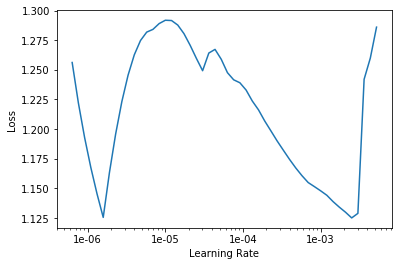

In [6]:
learn.recorder.plot()

In [9]:
lr = 1e-3

learn.fit(4, lr)

epoch,train_loss,valid_loss
1,1.067621,1.190639
2,1.036157,1.197886
3,1.022471,1.163918
4,1.024508,1.256187


In [64]:
img1 = Image.open('../../train/' + tr['Image'][0])
img2 = Image.open('../../train/' + tr['Image'][1])

img1 = img1.convert('RGB')
img2 = img2.convert('RGB')

img1 = SiameseTransforms_3(img1)
img2 = SiameseTransforms_3(img2)

img1 = np.array(img1, dtype=np.float32)# / 255.0
img2 = np.array(img2, dtype=np.float32)# / 255.0

torch.from_numpy(np.array([img1, img2])).size()

# img1 = np.array(img1)
# img2 = np.array(img2)

torch.Size([2, 3, 224, 224])

In [60]:
img1

array([[[-1.501413, -1.552787, -1.415789, -1.415789, ..., -1.364415, -1.073294, -0.679425, -0.696549],
        [-0.936296, -0.867797, -0.833547, -0.782173, ..., -1.809658, -1.655536, -1.467163, -1.415789],
        [-0.542427, -0.371179, -0.251306, -0.217056, ..., -1.313041, -1.244542, -1.244542, -1.210292],
        [-0.953421, -0.884922, -0.816423, -0.645175, ..., -1.004795, -1.056169, -1.158918, -1.158918],
        ...,
        [-0.867797, -0.919171, -0.970545, -1.039044, ..., -0.953421, -1.227417, -0.833547, -0.439678],
        [-1.124668, -1.124668, -1.124668, -0.953421, ..., -0.816423, -0.319805, -0.114308, -0.182807],
        [-1.107544, -1.193167, -1.227417, -1.176043, ..., -1.330165, -1.34729 , -1.467163, -1.484288],
        [-1.604161, -1.70691 , -1.758284, -1.792534, ..., -1.107544, -1.689785, -1.775409, -1.67266 ]],

       [[-0.95028 , -1.020308, -0.880252, -0.880252, ..., -0.862745, -0.512605, -0.092437, -0.127451],
        [-0.390056, -0.320028, -0.320028, -0.232493, ..., 

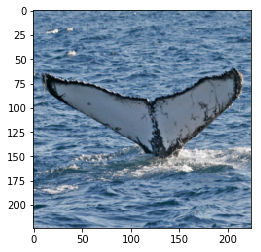

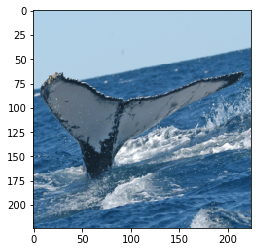

tensor([0.])

In [50]:
sample = train_dataset[0]
img1, img2 = sample[0]
label = sample[1]

plt.imshow(np.moveaxis(img1.numpy(), 0, -1)); plt.show()
plt.imshow(np.moveaxis(img2.numpy(), 0, -1)); plt.show()
label

We don't want to include the `new_whale` label in training, because we really can't establish if there happen to be any pairs existing in the dataset already.

In [73]:
img1.size()

torch.Size([3, 224, 224])

In [74]:
img1 = Image.open('../../train/' + tr['Image'][0])
img2 = Image.open('../../train/' + tr['Image'][1])

img1 = img1.convert('RGB')
img2 = img2.convert('RGB')

img1 = SiameseTransforms_2(img1)
img2 = SiameseTransforms_2(img2)

img1 = np.array(img1)
img2 = np.array(img2)

In [90]:
torch.from_numpy(np.moveaxis(np.array([img1, img2]), -1, 1)).size()

torch.Size([2, 3, 224, 224])

In [49]:
tst = next(iter(train_dataset))

In [50]:
is_listy(tst)

True

In [53]:
tst[0][0], tst[0][1]

(tensor([[[0.3961, 0.3686, 0.3412,  ..., 0.2667, 0.2549, 0.2588],
          [0.3804, 0.3922, 0.3961,  ..., 0.2588, 0.2588, 0.2667],
          [0.3608, 0.3843, 0.4000,  ..., 0.2471, 0.2588, 0.2745],
          ...,
          [0.2118, 0.1882, 0.2235,  ..., 0.3490, 0.3451, 0.3451],
          [0.1412, 0.1490, 0.1804,  ..., 0.3412, 0.3373, 0.3412],
          [0.1608, 0.1608, 0.2078,  ..., 0.3412, 0.3373, 0.3412]],
 
         [[0.5686, 0.5451, 0.5176,  ..., 0.4431, 0.4314, 0.4353],
          [0.5686, 0.5804, 0.5804,  ..., 0.4353, 0.4353, 0.4431],
          [0.5451, 0.5647, 0.5804,  ..., 0.4196, 0.4353, 0.4471],
          ...,
          [0.3529, 0.3294, 0.3569,  ..., 0.5608, 0.5529, 0.5529],
          [0.2941, 0.2902, 0.3020,  ..., 0.5608, 0.5569, 0.5569],
          [0.3020, 0.2941, 0.3255,  ..., 0.5569, 0.5529, 0.5529]],
 
         [[0.7647, 0.7412, 0.7216,  ..., 0.6667, 0.6549, 0.6549],
          [0.7608, 0.7725, 0.7804,  ..., 0.6588, 0.6588, 0.6588],
          [0.7412, 0.7608, 0.7804,  ...,

In [19]:
# vis_dataloader = DataLoader(train_dataset,
#                         num_workers=8,
#                         batch_size=8)
# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)

# concatenated = torch.cat((example_batch[0][0],example_batch[0][1]),0)
# plt.figure(figsize=(15,10))
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[1].numpy())

In [60]:
learn.fit(1)

epoch,train_loss,valid_loss


torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size([32, 2, 3, 224, 224])
torch.Size

torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Si

torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Si

torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])
torch.Size([1, 2, 3, 224, 224])


KeyboardInterrupt: 

In [9]:
tst = next(iter(mydb.train_dl))

In [10]:
xb, yb = next(iter(mydb.train_dl))

In [41]:
xb.size()

torch.Size([32, 2, 3, 224, 224])

In [51]:
xb[:,0,:,:]

tensor([[[[207, 201, 197,  ..., 196, 204, 200],
          [195, 196, 195,  ..., 187, 195, 199],
          [198, 203, 202,  ..., 186, 190, 198],
          ...,
          [227, 227, 231,  ..., 209, 220, 227],
          [218, 219, 225,  ..., 213, 222, 219],
          [211, 213, 218,  ..., 215, 221, 222]],

         [[207, 201, 197,  ..., 196, 204, 200],
          [195, 196, 195,  ..., 187, 195, 199],
          [198, 203, 202,  ..., 186, 190, 198],
          ...,
          [227, 227, 231,  ..., 209, 220, 227],
          [218, 219, 225,  ..., 213, 222, 219],
          [211, 213, 218,  ..., 215, 221, 222]],

         [[207, 201, 197,  ..., 196, 204, 200],
          [195, 196, 195,  ..., 187, 195, 199],
          [198, 203, 202,  ..., 186, 190, 198],
          ...,
          [227, 227, 231,  ..., 209, 220, 227],
          [218, 219, 225,  ..., 213, 222, 219],
          [211, 213, 218,  ..., 215, 221, 222]]],


        [[[180, 180, 185,  ..., 184, 189, 184],
          [188, 191, 189,  ..., 188

In [20]:
xb01, xb02 = xb[0]

In [21]:
learn.loss_func

ContrastiveLoss()

In [47]:
def loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    print("Check 3:", len(xb), len(yb))
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    print(len(*xb))
    out = model(*xb)
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss = cb_handler.on_backward_begin(loss)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()

    return loss.detach().cpu()

In [48]:
def fit(epochs:int, model:nn.Module, loss_func:LossFunction, opt:optim.Optimizer,
        data:DataBunch, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            model.train()
            cb_handler.on_epoch_begin()

            for xb,yb in progress_bar(data.train_dl, parent=pbar):
                print("Check 1:", len(xb), len(yb))
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                print("Check 2:", len(xb), len(yb))
                loss = loss_batch(model, xb, yb, loss_func, opt, cb_handler)
                if cb_handler.on_batch_end(loss): break

            if not data.empty_val:
                val_loss = validate(model, data.valid_dl, loss_func=loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            if cb_handler.on_epoch_end(val_loss): break
    except Exception as e:
        exception = e
        raise e
    finally: cb_handler.on_train_end(exception)

In [49]:
fit(1, net, criterion, None, mydb)

Check 1: 32 32
Check 2: 32 32
Check 3: 32 32
32
torch.Size([32, 2, 3, 224, 224])


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [30]:
loss_batch(net, xb, yb, criterion)

32
torch.Size([32, 2, 3, 224, 224])


ValueError: too many values to unpack (expected 2)

In [6]:
for epoch in range(0,1):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data
#         img0, img1 = imgs
#         print(img0.size(), img1.size())
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        outputs = net(img0,img1)
        loss_contrastive = criterion(outputs,label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 2 == 0 :
#             print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            iteration_number +=2
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
show_plot(counter,loss_history)

ValueError: not enough values to unpack (expected 3, got 2)

In [9]:
batch = next(iter(train_dataloader))

In [17]:
len(batch[0][0])

32

In [5]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,30):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
#         print(img0.size(), img1.size())
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 2 == 0 :
#             print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            iteration_number +=2
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
show_plot(counter,loss_history)

Epoch number 0
 Current loss 1.245479941368103

Epoch number 1
 Current loss 1.0320600271224976

Epoch number 2
 Current loss 0.9872223138809204

Epoch number 3
 Current loss 1.0112224817276

Epoch number 4
 Current loss 0.9399796724319458

Epoch number 5
 Current loss 0.9180481433868408

Epoch number 6
 Current loss 0.8271854519844055

Epoch number 7
 Current loss 0.8617570996284485

Epoch number 8
 Current loss 0.7907560467720032

Epoch number 9
 Current loss 0.774660050868988

Epoch number 10
 Current loss 0.7837092280387878

Epoch number 11
 Current loss 0.7960368990898132

Epoch number 12
 Current loss 0.7954298853874207

Epoch number 13
 Current loss 0.8075376749038696

Epoch number 14
 Current loss 0.7705219388008118

Epoch number 15
 Current loss 0.7987646460533142

Epoch number 16
 Current loss 0.7597269415855408

Epoch number 17
 Current loss 0.815321683883667

Epoch number 18
 Current loss 0.7603968381881714

Epoch number 19
 Current loss 0.784255862236023

Epoch number 20
 

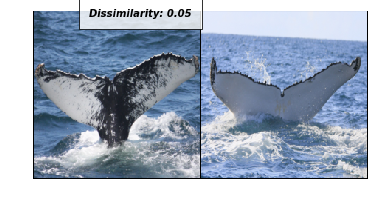

tensor([[1.]], device='cuda:0') 0.04646837338805199


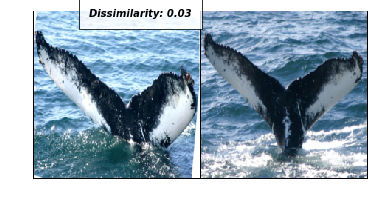

tensor([[0.]], device='cuda:0') 0.03208186849951744


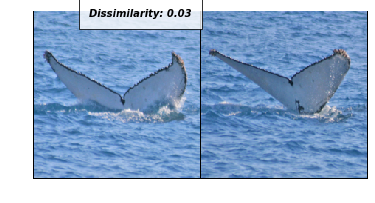

tensor([[0.]], device='cuda:0') 0.026706038042902946


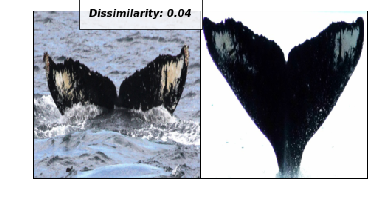

tensor([[0.]], device='cuda:0') 0.0403253473341465


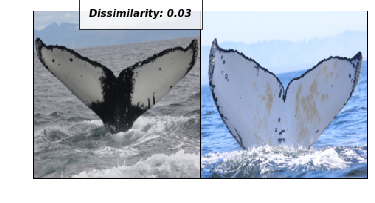

tensor([[1.]], device='cuda:0') 0.03478922322392464


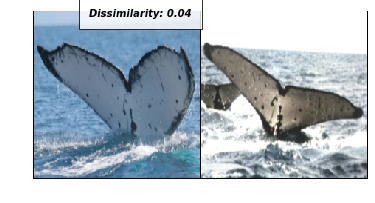

tensor([[0.]], device='cuda:0') 0.0405009426176548


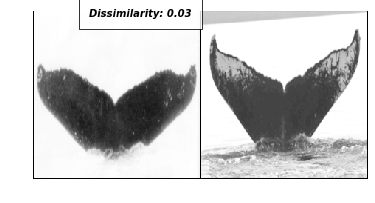

tensor([[1.]], device='cuda:0') 0.028908386826515198


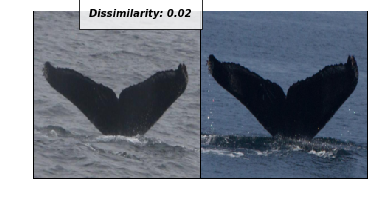

tensor([[0.]], device='cuda:0') 0.02289981208741665


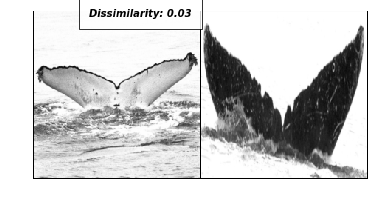

tensor([[1.]], device='cuda:0') 0.03411867097020149


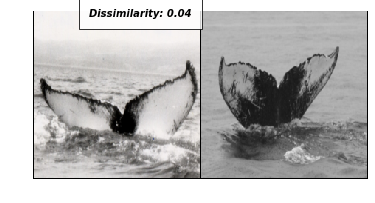

tensor([[1.]], device='cuda:0') 0.03516220301389694


In [7]:
val_dataloader = DataLoader(val_dataset,num_workers=1,batch_size=1,shuffle=True)
dataiter = iter(val_dataloader)

# for i, data in enumerate(val_dataloader,0):
for i in range(10):
    img0, img1 , label = next(dataiter)
    concatenated = torch.cat((img0,img1),0)

    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
    output1,output2 = net(img0,img1)
    euclidean_distance = F.pairwise_distance(output1, output2)

    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(label, euclidean_distance.item())
# for i in range(10):
#     _,x1,label2 = next(dataiter)
#     concatenated = torch.cat((x0,x1),0)
    
#     output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

## To Do: 
Will need to define the ability to do transforms, and how to actually use the batch size, etc.

In [ ]:
ImageDataBunch()

In [47]:
train_sampler = RandomSampler(sd)
sdl = SiameseDataLoader('../../train/', tr, same, diff, sampler=train_sampler)

In [48]:
len(sdl)

2073

In [50]:
next(sdl)

TypeError: 'SiameseDataLoader' object is not an iterator

In [14]:
tr.head()

,Image,Id,x,y,channels
0,0000e88ab.jpg,w_f48451c,700,1050,3
1,0001f9222.jpg,w_c3d896a,325,758,3
2,00029d126.jpg,w_20df2c5,497,1050,3
3,00050a15a.jpg,new_whale,525,1050,3
4,0005c1ef8.jpg,new_whale,525,1050,3


In [35]:
np.random.choice(tr[tr['Id']=='w_f48451c']['Image'].values)

'e2f1b6c4a.jpg'

In [37]:
tst1, tst2 = np.random.choice(tr[tr['Id']=='w_f48451c']['Image'].values, size=2)

In [39]:
tst1, tst2

('0000e88ab.jpg', '9fc84d2ae.jpg')

In [58]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2, similarity_label):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[similarity_label]
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self

In [ ]:
class ImageTupleList(ImageItemList):
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res

    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

class ImageTupleList(ImageItemList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)